In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path

import keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers, optimizers, Sequential
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
def load_train_images():
    df = pd.read_csv('train.csv')
    imgs = []
    img_labels = []

    for img_id, labels in zip(df.image_id.values, df.labels.values):        
        try:
            image = tf.keras.preprocessing.image.load_img(os.path.join('images', img_id),
                    target_size=(300, 300),
                    keep_aspect_ratio = True,
                    color_mode = 'rgb')
            input_arr = tf.keras.preprocessing.image.img_to_array(image)

            image = np.expand_dims(input_arr, axis=0)
            image = image/255
            image = np.squeeze(image)
            imgs.append(image)

            label_int = list(map(int, labels.replace('l', '').split(' ')))
            labels = np.zeros(92)
            labels[label_int] = 1.0

            img_labels.append(labels)
            
        except FileNotFoundError:
            print(img_id, 'doesnt exist')

    return np.array(imgs), img_labels

In [3]:
def load_test_images():
    df = pd.read_csv('test.csv')
    imgs = []

    for img_id in df.image_id.values:
        
        try:
            
            image = tf.keras.preprocessing.image.load_img(os.path.join('images', img_id),
                    target_size=(300, 300),
                    keep_aspect_ratio = True,
                    color_mode = 'rgb')
            input_arr = tf.keras.preprocessing.image.img_to_array(image)
            
            image = np.expand_dims(input_arr, axis=0)
            image = image/255
            image = np.squeeze(image)

            imgs.append(image)

        except FileNotFoundError:
            print(img_id, 'doesnt exist')

    return np.array(imgs)

In [4]:
test_imgs = load_test_images()
train_imgs, labels = load_train_images()

img285.jpg doesnt exist
img288.jpg doesnt exist
img286.jpg doesnt exist
img172.jpg doesnt exist
img244.jpg doesnt exist
img287.jpg doesnt exist


In [5]:
test_imgs.shape, train_imgs.shape

((86, 300, 300, 3), (201, 300, 300, 3))

In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_imgs, labels, random_state = 999, test_size = 0.10)

In [7]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = "nearest"
    )

datagen.fit(X_train)

In [8]:
def get_f1(y_true, y_pred): #https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [9]:
# InceptionV3 model

def run():
    
    inceptionv3_model = Sequential()

    pre_trained_model= InceptionV3(include_top=False,
                       input_shape = (300, 300, 3),
                       pooling = 'avg',
                       classes = 92,
                       weights = 'imagenet')

    for layer in pre_trained_model.layers:
            layer.trainable=False

    inceptionv3_model.add(pre_trained_model)
    inceptionv3_model.add(Flatten())
    inceptionv3_model.add(Dense(512, activation='relu'))

    inceptionv3_model.add(Dropout(rate = 0.9))

    inceptionv3_model.add(Dense(92, kernel_initializer= tf.keras.initializers.GlorotUniform(seed=999), activation='sigmoid'))

    inceptionv3_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                          metrics=[tf.keras.metrics.BinaryAccuracy(),
                                  get_f1], 
                          optimizer=optimizers.Adam(learning_rate=0.0001))

    inceptionv3_model.summary()
    return inceptionv3_model

In [10]:
history_wo = run().fit(X_train, np.array(y_train), batch_size=64,
                        steps_per_epoch=X_train.shape[0]//64,
                        epochs=25,
                        verbose=1,
                        validation_data=(X_val, np.array(y_val)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 92)                47196     
                                                                 
Total params: 22,899,068
Trainable params: 1,096,284
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/25
2/2 [====================

In [11]:
history_w = run().fit(datagen.flow(X_train, np.array(y_train), batch_size=64),
                        steps_per_epoch=X_train.shape[0]//64,
                        epochs=25,
                        verbose=1,
                        validation_data=(X_val, np.array(y_val)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 92)                47196     
                                                                 
Total params: 22,899,068
Trainable params: 1,096,284
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/25
2/2 [==================

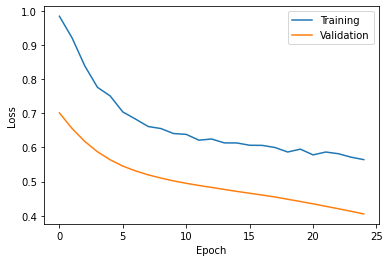

In [12]:
plt.subplot()
plt.plot(history_wo.history['loss'])
plt.plot(history_wo.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

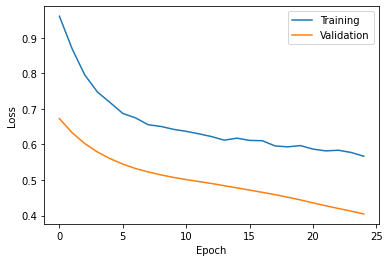

In [13]:
plt.subplot()
plt.plot(history_w.history['loss'])
plt.plot(history_w.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])

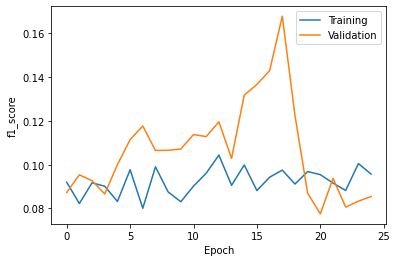

In [14]:
plt.subplot()
plt.plot(history_wo.history['get_f1'])
plt.plot(history_wo.history['val_get_f1'])
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend(['Training', 'Validation'])

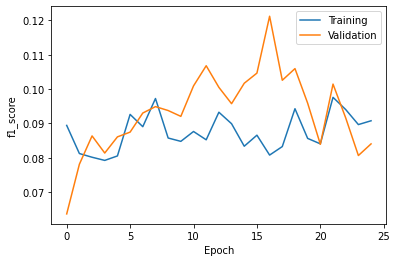

In [15]:
plt.subplot()
plt.plot(history_w.history['get_f1'])
plt.plot(history_w.history['val_get_f1'])
plt.xlabel('Epoch')
plt.ylabel('f1_score')
plt.legend(['Training', 'Validation'])